# Facial Keyponts Detection

https://www.kaggle.com/c/facial-keypoints-detection

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from pandas.io.parsers import read_csv
from random import randrange

## Carregando os dados

In [2]:
def load(file, test=False, cols=None):
    '''
    Carrega o dataset.
    
    file: arquivo a ser carregado
    test: indica se o arquivo contém dados de teste ou treino
    cols: carrega algumas colunas específicas
    '''

    # carrega os dados como dataframe do pandas
    df = read_csv(file)

    # converte os dados para array numpy
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep = ' '))

    # seleciona somente algumas colunas
    if cols:
        df = df[list(cols) + ['Image']]

    # descarta linhas com dados faltando
    df = df.dropna()

    if not test:  # only FTRAIN has target columns
        y = df[df.columns[:-1]].values
    else:
        y = None

    return (df, y)

In [3]:
train_file = 'data/training.csv'
test_file = 'data/test.csv'

In [4]:
X, y = load(train_file)

In [5]:
X_test, _ = load(test_file, test=True)

## Normalização dos dados

In [6]:
def normalize(X, y=None, image_size=96, channels=1):
    '''
    Normaliza os dados
    X: imagens para normalização
    y: labels para normalização
    image_size: tamanho da imagem
    channels: canais para conversão
    '''
    
    X = np.vstack(X['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)
    X = X.reshape(-1, image_size, image_size, channels)

    if y is not None:
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        y = y.astype(np.float32)
        
    return (X, y)

In [7]:
channels = 1
image_size = 96

X, y = normalize(X, y, image_size, channels)
X_test, _ = normalize(X_test, image_size=image_size, channels=channels)

print(X.shape)
print(y.shape)
print(X_test.shape)

(2140, 96, 96, 1)
(2140, 30)
(1783, 96, 96, 1)


## Plotando alguns exemplos

In [8]:
def plot_image(x, y, ax):
    '''
    Plota uma imagem com os keypoints

    x: imagem
    y: keypoints
    ax: matplotlib axis
    '''
    img = x.reshape(96, 96)
    ax.imshow(img, cmap='gray')
    ax.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, c='cyan', marker='o', s=10)

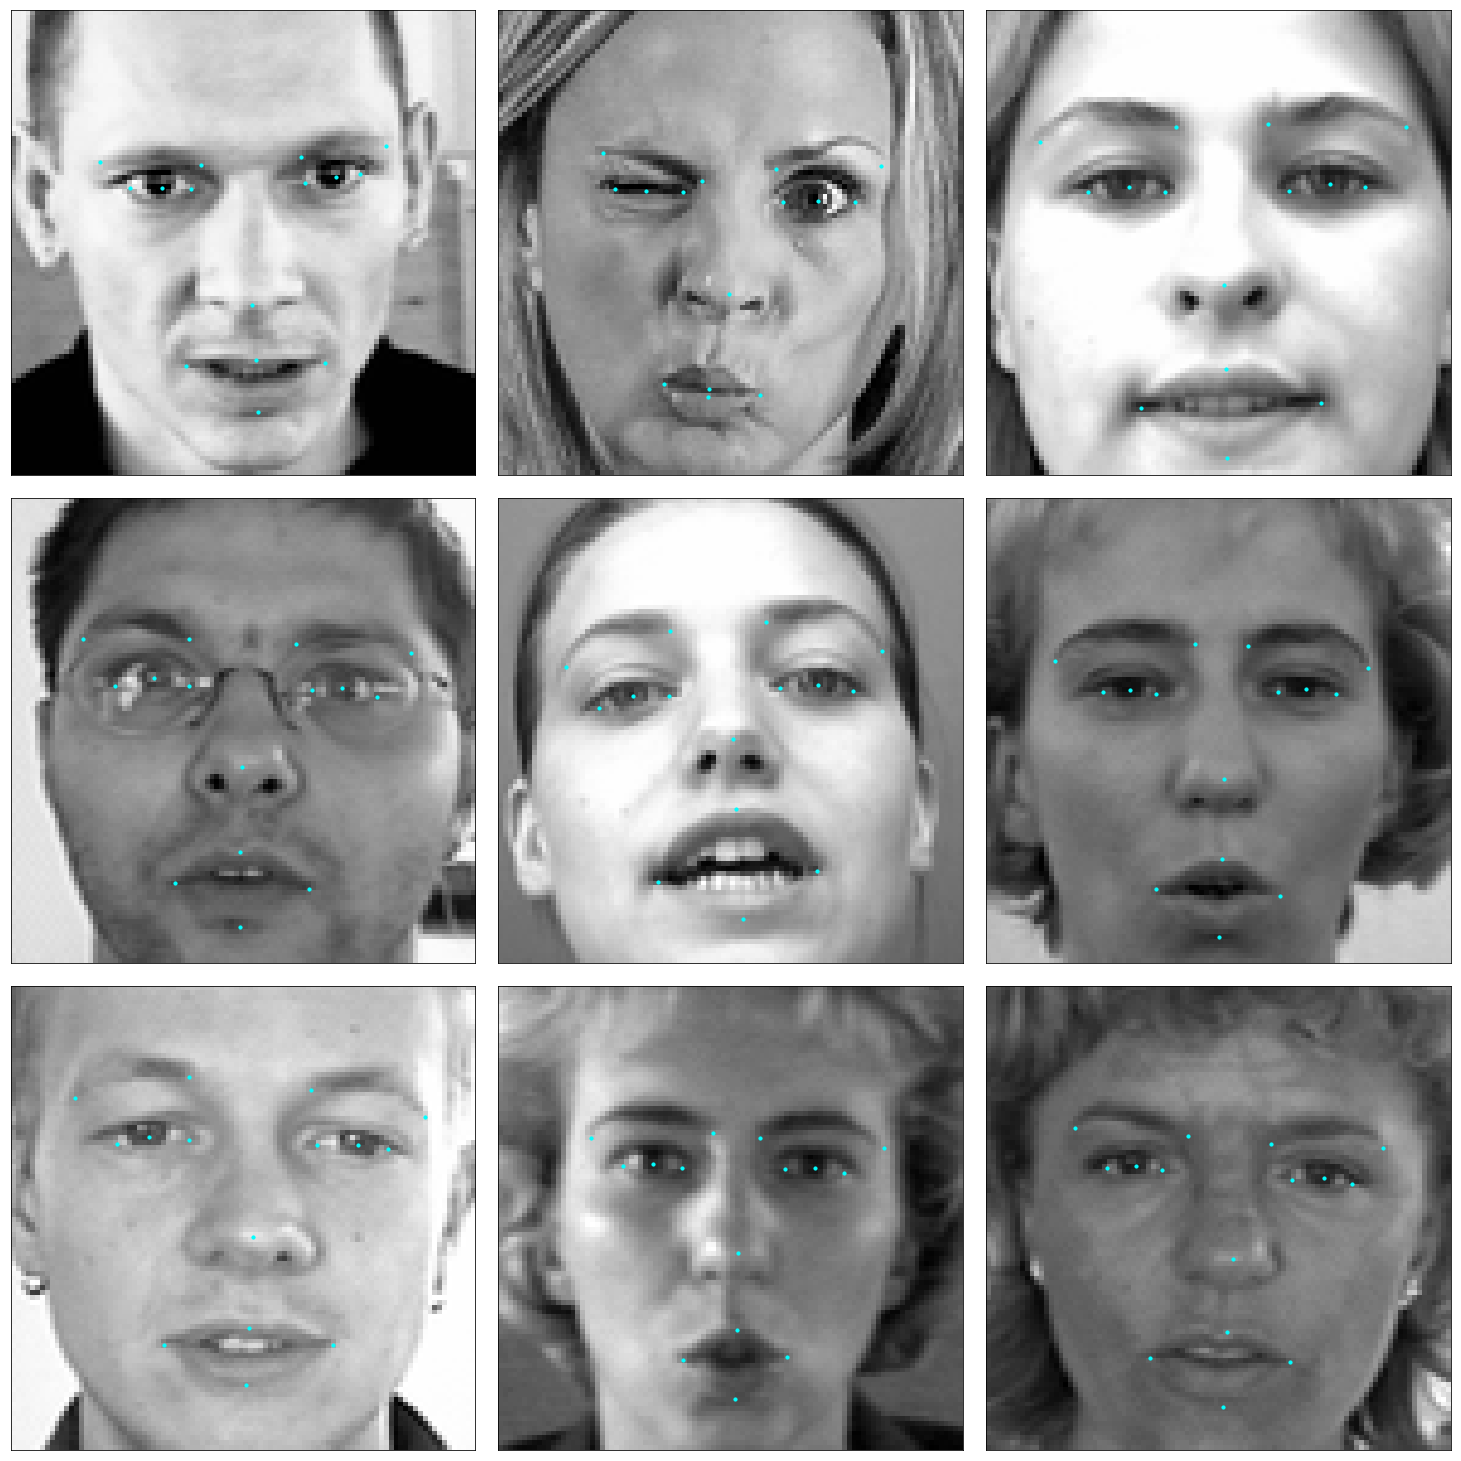

In [9]:
fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(9):
    img = randrange(0, X.shape[0])
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    plot_image(X[img], y[img], ax)

## Construindo o modelo

In [10]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from keras.layers import Flatten, Dense
from keras.layers.normalization import BatchNormalization

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=(96, 96, 1)))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(30))

model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 94, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         73856     
__________

## Compilando e treinando

In [11]:
from keras.callbacks import ModelCheckpoint, History, ReduceLROnPlateau

epochs = 50
batch_size = 64

history = History()
checkpointer = ModelCheckpoint(filepath='weights.hdf5', verbose=1, save_best_only=True)
lrreduction = ReduceLROnPlateau(monitor='val_acc', patience=7, verbose=1, factor=0.8, min_lr=0.00001)

model.compile(optimizer='rmsprop', loss='mse', metrics=['accuracy'])

history_final = model.fit(X, y, validation_split=0.2,
          epochs=epochs, batch_size=batch_size, callbacks=[checkpointer, history, lrreduction], verbose=1)

model.save('model.h5')

Train on 1712 samples, validate on 428 samples
Epoch 1/50
1712/1712 [==============================] - 12s - loss: 0.0554 - acc: 0.5152 - val_loss: 0.0150 - val_acc: 0.4322
Epoch 2/50
1712/1712 [==============================] - 12s - loss: 0.0163 - acc: 0.6431 - val_loss: 0.0215 - val_acc: 0.4322
Epoch 3/50
1712/1712 [==============================] - 12s - loss: 0.0135 - acc: 0.6717 - val_loss: 0.0097 - val_acc: 0.4322
Epoch 4/50
1712/1712 [==============================] - 12s - loss: 0.0094 - acc: 0.7056 - val_loss: 0.0108 - val_acc: 0.4322
Epoch 5/50
1712/1712 [==============================] - 12s - loss: 0.0076 - acc: 0.7044 - val_loss: 0.0083 - val_acc: 0.4322
Epoch 6/50
1712/1712 [==============================] - 12s - loss: 0.0068 - acc: 0.7319 - val_loss: 0.0079 - val_acc: 0.4322
Epoch 7/50
1712/1712 [==============================] - 12s - loss: 0.0060 - acc: 0.7377 - val_loss: 0.0102 - val_acc: 0.4322
Epoch 8/50
1712/1712 [==============================] - 12s - loss: 0.0

1712/1712 [==============================] - 13s - loss: 0.0016 - acc: 0.8277 - val_loss: 0.0046 - val_acc: 0.5000
Epoch 32/50
1712/1712 [==============================] - 12s - loss: 0.0014 - acc: 0.8353 - val_loss: 0.0042 - val_acc: 0.4953
Epoch 33/50
1712/1712 [==============================] - 12s - loss: 0.0015 - acc: 0.8429 - val_loss: 0.0039 - val_acc: 0.4930
Epoch 34/50
1712/1712 [==============================] - 12s - loss: 0.0013 - acc: 0.8429 - val_loss: 0.0041 - val_acc: 0.4860
Epoch 35/50
1712/1712 [==============================] - 12s - loss: 0.0014 - acc: 0.8499 - val_loss: 0.0038 - val_acc: 0.5234
Epoch 36/50
1712/1712 [==============================] - 12s - loss: 0.0013 - acc: 0.8423 - val_loss: 0.0040 - val_acc: 0.4813
Epoch 37/50
1712/1712 [==============================] - 12s - loss: 0.0013 - acc: 0.8458 - val_loss: 0.0041 - val_acc: 0.5210
Epoch 38/50
1712/1712 [==============================] - 13s - loss: 0.0012 - acc: 0.8540 - val_loss: 0.0038 - val_acc: 0.4

## Visualizando o erro de treinamento e validação

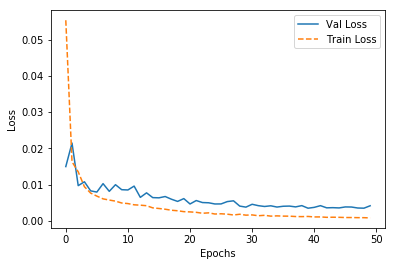

In [15]:
plt.plot(range(epochs), history_final.history['val_loss'], '-', label='Val Loss')
plt.plot(range(epochs), history_final.history['loss'], '--', label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Avaliando a rede no conjunto de testes

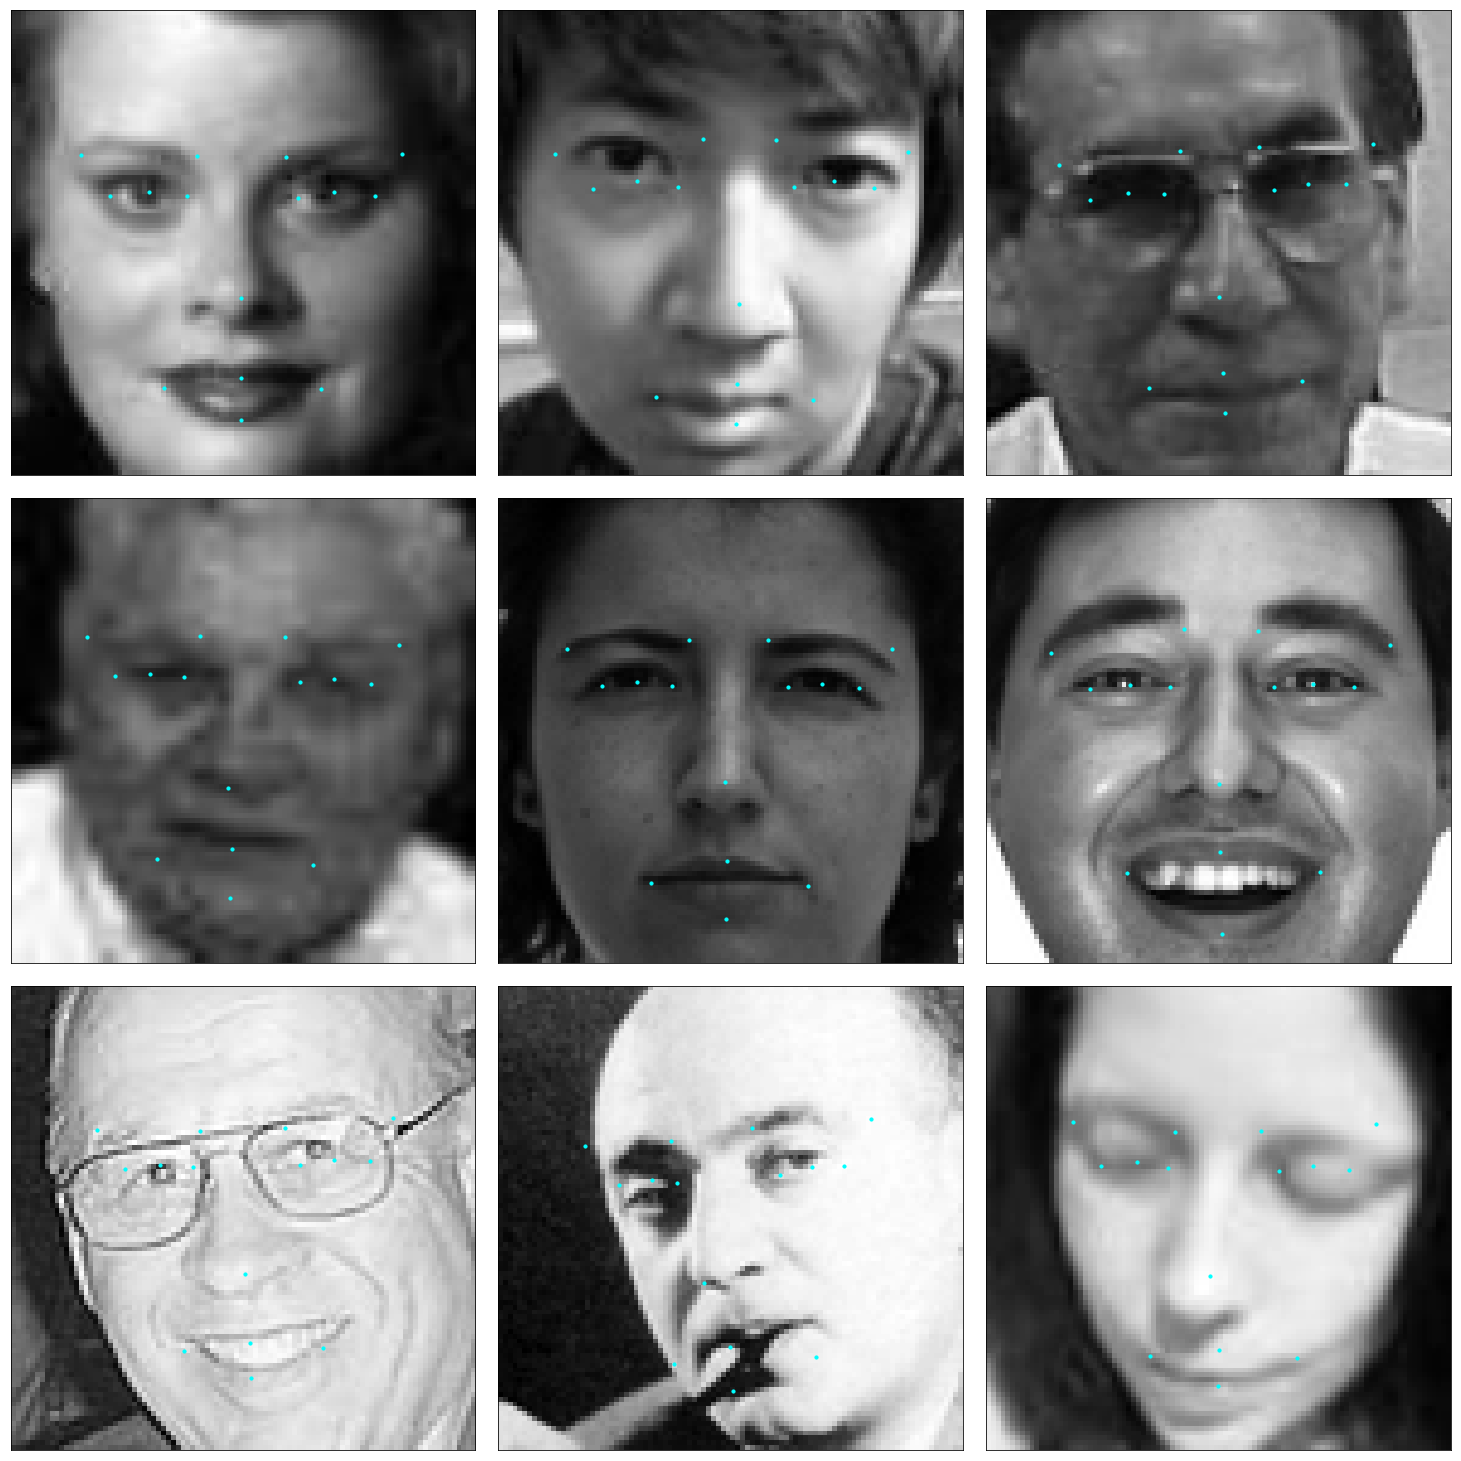

In [17]:
y_test = model.predict(X_test)
fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(9):
    img = randrange(0, X_test.shape[0])
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    plot_image(X_test[img], y_test[img], ax)